In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)


2.1.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [35]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    返回用于迭代的dataset
    for x,y in dataset:
        print("x = ", x.numpy())
        print("y = ", y.numpy())
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [36]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# for x,y in dataset:
#     print("x = ", x.numpy())
#     print("y = ", y.numpy())

In [44]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.03143632],
       [-0.03739781],
       [ 0.01833301],
       [ 0.06351747],
       [ 0.0226197 ],
       [-0.01972145],
       [-0.01420927],
       [-0.00061275],
       [-0.0543271 ],
       [ 0.06145177],
       [-0.01779877],
       [ 0.03583005],
       [-0.07269743],
       [ 0.03551777],
       [ 0.03043562],
       [ 0.05712786],
       [ 0.07284276],
       [ 0.09713437],
       [ 0.32927543],
       [ 0.41795453]], dtype=float32), array([0.01447843], dtype=float32)]


In [50]:
series[time:time + window_size][np.newaxis]

array([[87.6617  , 90.24545 , 85.314125, 77.95596 , 86.46982 , 81.246   ,
        81.891266, 87.49788 , 90.78933 , 84.73629 , 86.206245, 93.20547 ,
        85.930595, 97.76784 , 87.619705, 76.02122 , 88.624756, 86.79699 ,
        91.37325 , 88.32383 ]], dtype=float32)

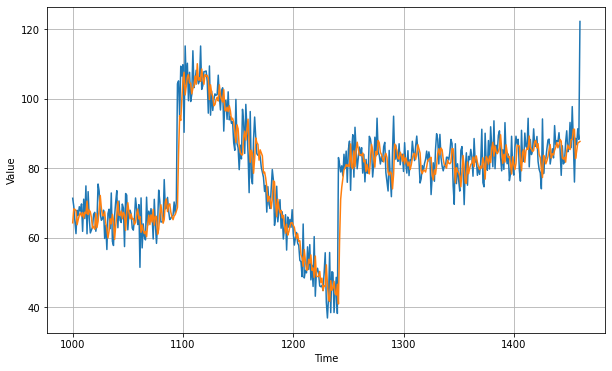

In [46]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9415097

### 三层神经网络模型

In [52]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

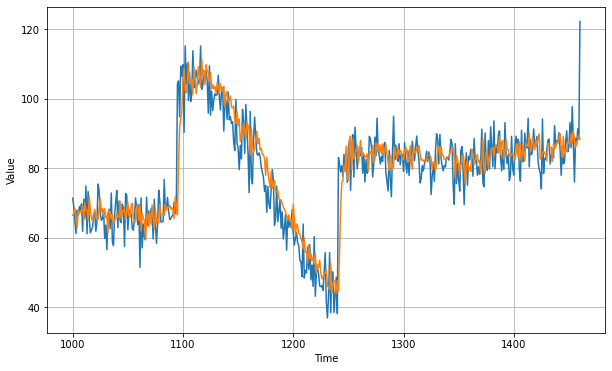

In [53]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [54]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.165475

### 超参数调整

In [55]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

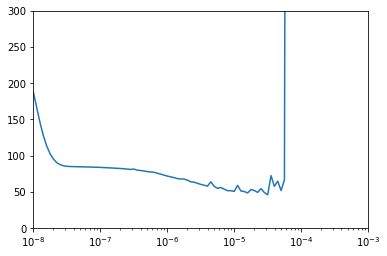

In [56]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [57]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

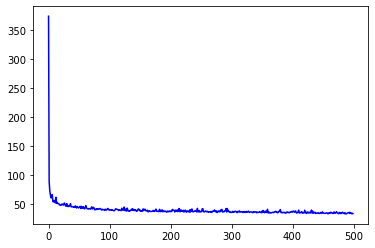

In [58]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[55.233908631629554, 51.74124327197517, 61.10825849316784, 50.430907668280845, 52.711884807311385, 50.16605071234949, 50.3635439253345, 50.11908775014976, 47.75429193555694, 48.084615837175825, 47.29061844422645, 47.873822151262736, 49.505287201871575, 49.300223218780204, 47.57975677018313, 48.08741543170103, 51.233484838426726, 48.64304193319734, 45.99219441364721, 46.00385482630779, 50.07602097029538, 45.16892231420143, 46.52602614176642, 45.02277640509851, 45.75474853515625, 47.066327411612285, 49.99328222766365, 44.547186074797644, 44.70616828682496, 45.01856138878262, 44.44528405887564, 43.94416757170687, 44.95711827622247, 43.6044260713243, 46.304605487941465, 44.54964115496763, 42.6268507652676, 45.16013815181771, 44.01186578494986, 42.8652441870306, 43.19386035093327, 44.50882490099091, 45.41290692201595, 41.654071328074664, 45.36132207654186, 43.39954960223326, 42.08930172477801, 44.93852285798063, 42.41698019676602, 41.06416107649655, 42.52253935509121, 46.82246350160579, 43.

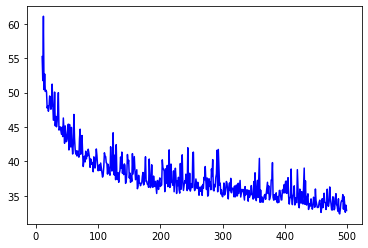

In [59]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

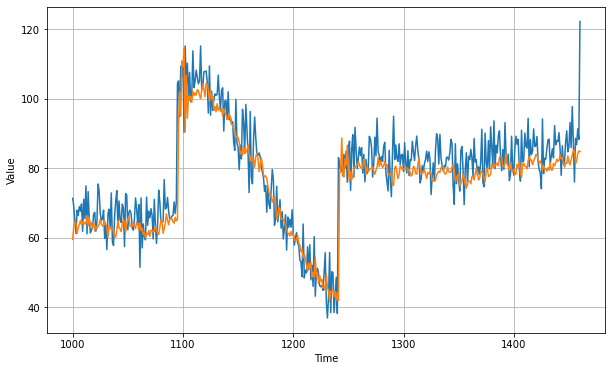

In [60]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [61]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2229238